<a href="https://colab.research.google.com/github/CallmeQuant/Studying-Notebook/blob/main/A-B-Testing/A_B_Testing_Udacity_Screener.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Environment Setups**

In [159]:
from google.colab import drive
drive.mount("/content/drive")
from google.colab import files

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Installing Modules**

In [160]:
%%capture
!pip install catboost
!pip install treeinterpreter

## **Importing Libraries**

In [161]:
import pandas as pd
import numpy as np

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
# Plotting params

plot_params = {
    "font.size": 15,
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.grid": True,
    "grid.linestyle": "-",
    "grid.linewidth": 0.5,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.labelsize": 15,
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "axes.titlesize": 18,
    "figure.dpi": 150,
    "figure.constrained_layout.use": True,
    "figure.autolayout": False}

plt.style.use("ggplot")
plt.rcParams.update(plot_params)
# plt.rcParams["font.size"] = 15
# # plt.rcParams['axes.facecolor'] = 'white'
# # Set the background color to white
# plt.rcParams['figure.facecolor'] = 'white'
# plt.rcParams['axes.facecolor'] = 'white'

# # Only show major gridlines
# plt.rcParams['axes.grid'] = True
# plt.rcParams['grid.linestyle'] = '-'
# plt.rcParams['grid.linewidth'] = 0.5

# # Only show left and bottom axes
# plt.rcParams['axes.spines.top'] = False
# plt.rcParams['axes.spines.right'] = False
COLORS = list(sns.color_palette())

# **Data Processing**

## **Printing Function**

In [162]:
# Printing information function
def print_info(info, *args):
  print(
      '-'*len(info),
      info,
      '-'*len(info),
      *args,
      sep = '\n'
  )

## **Data Loading**

In [163]:
control = pd.read_csv("drive/My Drive/data/control_data.csv")
experiment = pd.read_csv("drive/My Drive/data/experiment_data.csv")

## **Data Examining**

### **Basic Information**

We have 5 columns consisting of:

+ Date: a character formatted Day, Month, and Day of Month
+ Pageviews: An aggregated count of Page Views on the given day
+ Clicks: An aggregated count of Page Clicks on the given day for the page in question
+ Enrollments: An aggregated count of Enrollments by day.
+ Payments: An aggregated count of Payments by day.

In [164]:
control.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         37 non-null     object 
 1   Pageviews    37 non-null     int64  
 2   Clicks       37 non-null     int64  
 3   Enrollments  23 non-null     float64
 4   Payments     23 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 1.6+ KB


In [165]:
experiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         37 non-null     object 
 1   Pageviews    37 non-null     int64  
 2   Clicks       37 non-null     int64  
 3   Enrollments  23 non-null     float64
 4   Payments     23 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 1.6+ KB


We draw some points about our data as below:

+ Both control and experiment sets consist of 37 observations.
Data is time-based and aggregated by day. Moreover, the `Date` between these two groups are the same since two groups are recorded simultaneously.

+ `Date` is formatted as a `character` data type. Since we are not provided the year of the recording date, the `Date` column is pretty uninformative. However, we'll extract day of the week features out of it and use this as a predictor for our models.

### **Missing Values**

We have 14 days of missing observations. Moreover, the missing data occuring in two data sets are identical, which is consistent to the nature of the experiment. For these missing values, we will discard them.

In [166]:
def create_missing_df(df):
  missing_df = df.isna().sum().to_frame(name = 'Missing')
  # missing_df['Non-missing'] = missing_df['Missing'].apply(lambda x: 100 - x)
  missing_df['Non-missing'] = len(df) - missing_df['Missing']
  missing_df['%missing'] = missing_df['Missing']*100/len(df)
  missing_df['%non-missing'] = 100 - missing_df['%missing']
  return missing_df

missing_control = create_missing_df(control)
missing_experiment = create_missing_df(control)

<ipython-input-167-5a5cd540c43d>:33: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


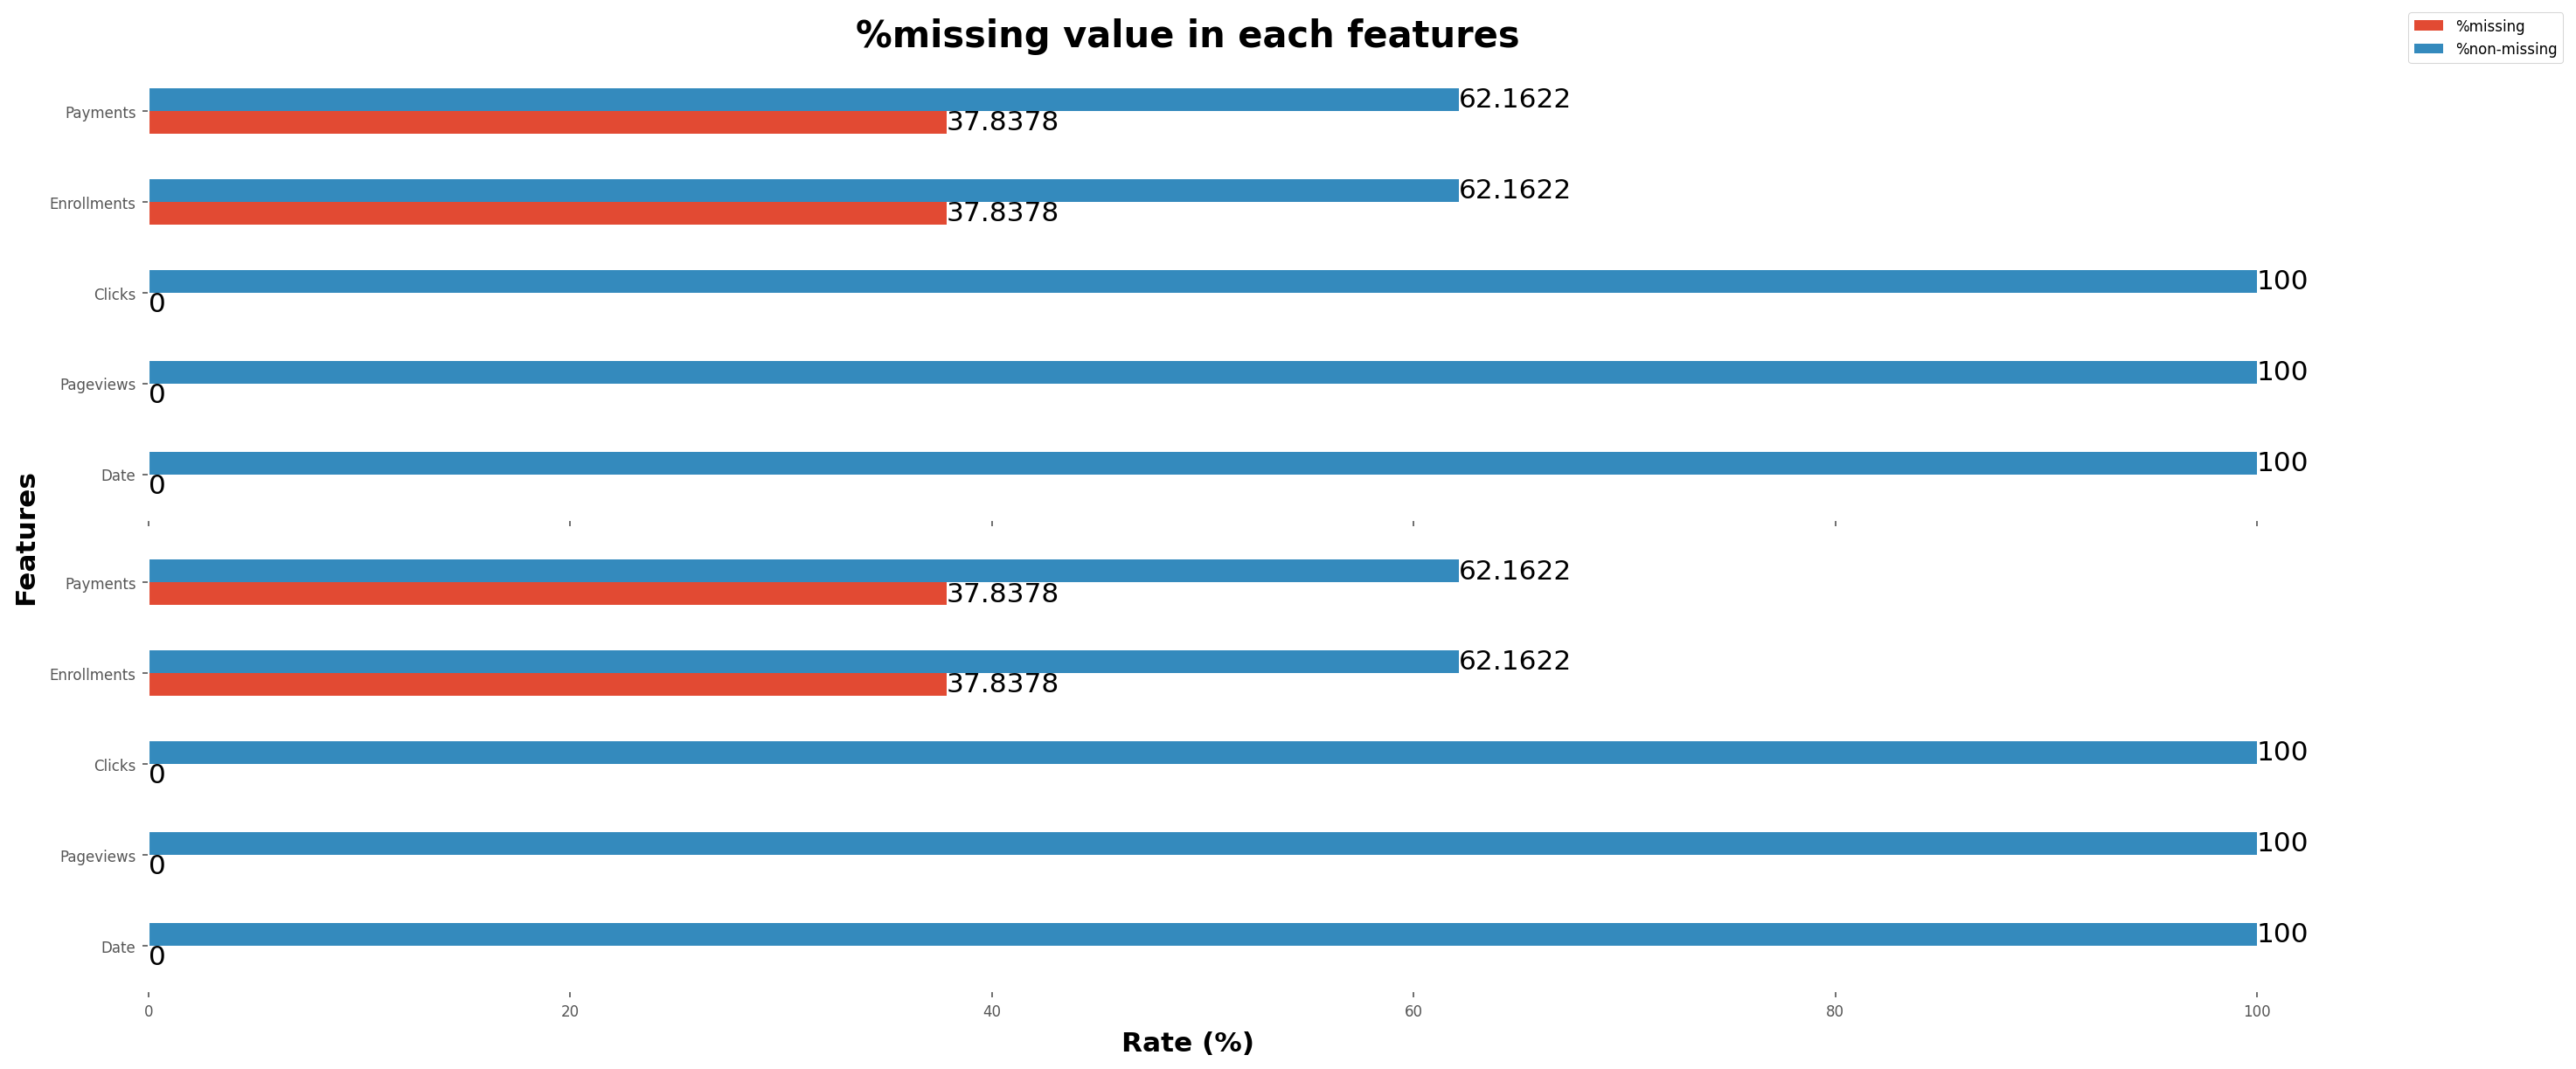

In [167]:
A4 = (8.3, 11.7)
hfigsize = (20,10)
vfigsize = (10,20)

def create_subplots(figsize, row = 1, col = 1, sharex=True, sharey=True,):
    return plt.subplots(row, col, figsize = figsize, sharex = sharex, sharey = sharey)

fig, (ax1, ax2) = create_subplots(figsize = (18 ,8), row = 2, col = 1, )
fig.suptitle('%missing value in each features', fontsize = 20, fontweight = 'bold')
fig.supylabel('Features', fontsize = 15, fontweight = 'bold')
fig.supxlabel('Rate (%)', fontsize = 15, fontweight = 'bold')

missing_control[['%missing', '%non-missing']].plot.barh(ax = ax1,
                                                        align = 'center',
                                                        color = COLORS[:2],
                                                        legend = False)
for bar in ax1.containers:
    ax1.bar_label(bar)

missing_experiment[['%missing', '%non-missing']].plot.barh(ax = ax2,
                                                           align = 'center',
                                                           color = COLORS[:2],
                                                           legend = False)
for bar in ax2.containers:
    ax2.bar_label(bar)

for ax in fig.get_axes():
    ax.label_outer()

handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1.05, 1),
           loc='upper center', borderaxespad=0)
plt.tight_layout()

## **Data Cleaning**

Now that we understand the data, let's put it into the correct structure that we can use for modeling. To attain nicely formatted data, the following steps will be performed:

+ Combining the control dataset and experiment dataset.
+ Checking if there is any duplicated values and examining the data type of each features.
+ Adding an `id` column indicating if the data was part of the experiment or not.
+ Adding a `row_id` column to help for tracking which rows are selected for training and testing in the modeling section.
+ Create a `Day of Week` feature from the `Date` column.
+ Drop the unnecessary `Date` column and the `Payments` column.
+ Handle the missing data (NA) by removing these rows.
+ Shuffle the rows to mix the data up for learning.
+ Reorganizing the columns.

In [168]:
np.random.seed(123)

# Combine with Experiment data
data_clean = pd.concat([control, experiment], keys=['0', '1'], names=['Experiment'])
idx = data_clean.index
data_clean.reset_index(level='Experiment', inplace=True)

# Convert Experiment to numeric
data_clean['Experiment'] = pd.to_numeric(data_clean['Experiment'])

# Add row id

data_clean = data_clean.reset_index().rename(columns={'index': 'row_id'})

# Create a Day of Week feature
data_clean['DOW'] = data_clean['Date'].str.slice(start=0, stop=3)
data_clean['DOW'] = pd.Categorical(data_clean['DOW'], categories=["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"], ordered=True)

# Drop Date and Payments columns
data_clean.drop(['Date', 'Payments'], axis=1, inplace=True)

# Remove missing data
data_clean.dropna(subset=['Enrollments'], inplace=True)

# Shuffle the data (note that np.random.seed is used to make reproducible)
data_clean = shuffle(data_clean)

# Reorganize columns
cols = ['row_id', 'Enrollments', 'Experiment'] + [col for col in data_clean.columns if col not in ['row_id', 'Enrollments', 'Experiment']]
data_clean = data_clean[cols]

# **Modeling**

## **Ultis Function**

In [169]:
def calculate_metrics(y_test, y_preds):
    rmse = np.sqrt(mean_squared_error(y_test, y_preds))
    r_sq = r2_score(y_test, y_preds)
    mae = mean_absolute_error(y_test, y_preds)

    print('RMSE Score: {}'.format(rmse))
    print('R2_Squared: {}'.format(r_sq))
    print('MAE Score: {}'.format(mae))

def plot_preds(y_test, y_preds, model_name):
    N = len(y_test)
    plt.figure(figsize=(10,5))
    original = plt.scatter(np.arange(1, N+1), y_test, color=COLORS[2])
    prediction = plt.scatter(np.arange(1, N+1), y_preds, color=COLORS[5])
    plt.xticks(np.arange(1, N+1))
    plt.xlabel('Oberservations')
    plt.ylabel('Enrollments')
    title = 'True labels vs. Predicted Labels ({})'.format(model_name)
    plt.title(title, fontsize = 15, fontweight = 'bold')
    plt.legend((original, prediction), ('Original', 'Prediction'),
               bbox_to_anchor=(1, 1), shadow = True)
    plt.show()

## **Data Splitting**

In [170]:
X_train, X_test, y_train, y_test = train_test_split(data_clean.loc[:, data_clean.columns != 'Enrollments'],\
                                                    data_clean['Enrollments'], test_size=0.2)

## **Encoding Categorical Variables**

In [171]:
# Converting strings to numbers

lb = LabelEncoder()
X_train['DOW'] = lb.fit_transform(X_train['DOW'])
X_test['DOW'] = lb.transform(X_test['DOW'])

## **Training and Predicting**

In [172]:
X_train_refined = X_train.drop(columns=['row_id'], axis=1)
X_train_refined = sm.add_constant(X_train_refined)
linear_regression = sm.OLS(y_train, X_train_refined)
linear_regression = linear_regression.fit()

In [173]:
X_test_refined = X_test.drop(columns=['row_id'], axis=1)
X_test_refined = sm.add_constant(X_test_refined)
y_preds = linear_regression.predict(X_test_refined)

In [174]:
calculate_metrics(y_test, y_preds)

RMSE Score: 27.383434270631835
R2_Squared: -0.24238265036452722
MAE Score: 22.14003368931256


## **Plotting Predictions**

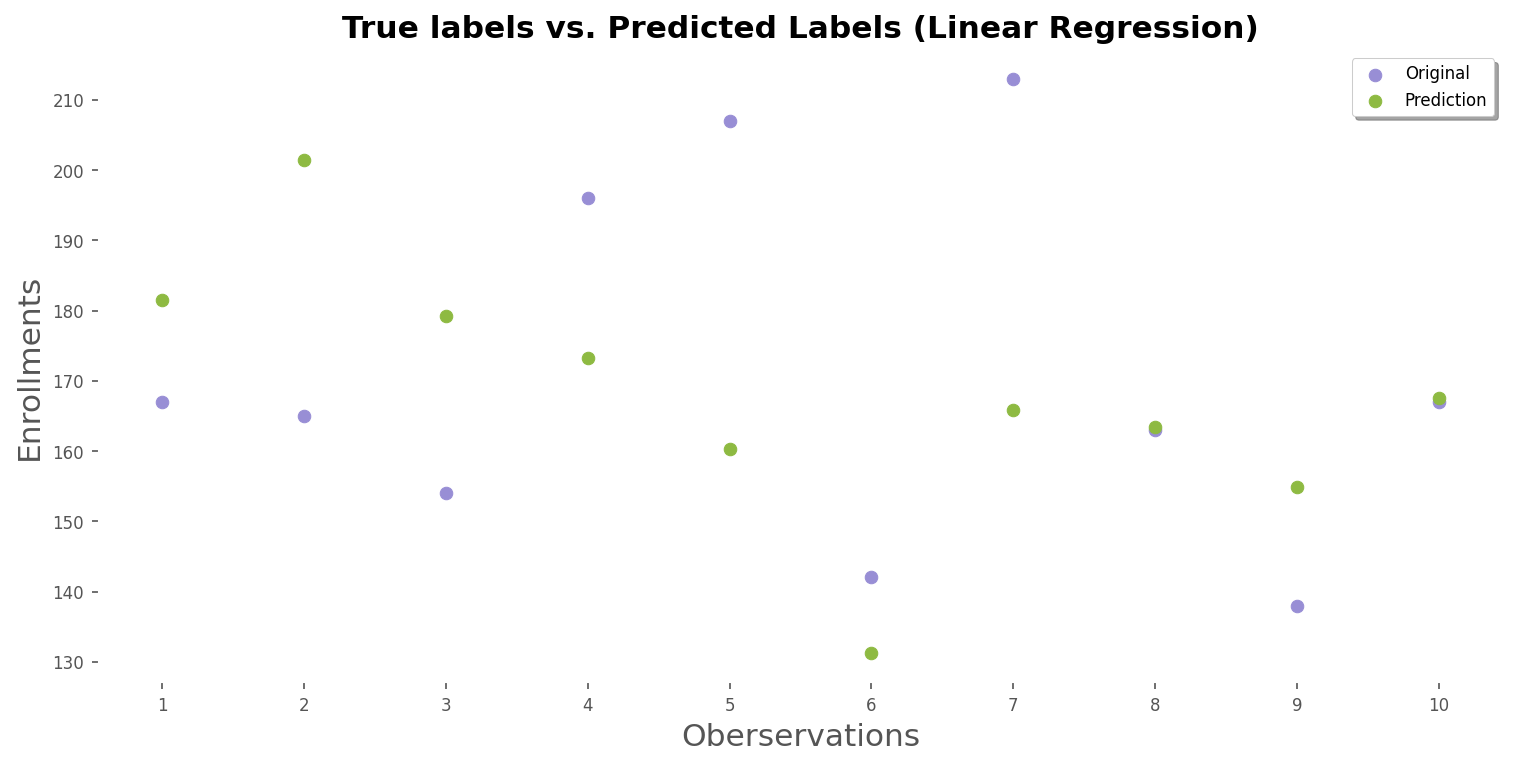

In [175]:
plot_preds(y_test, y_preds, 'Linear Regression')

## **Interpreting**

In [176]:
print(linear_regression.summary())

                            OLS Regression Results                            
Dep. Variable:            Enrollments   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     11.90
Date:                Tue, 12 Sep 2023   Prob (F-statistic):           5.65e-06
Time:                        20:44:25   Log-Likelihood:                -159.73
No. Observations:                  36   AIC:                             329.5
Df Residuals:                      31   BIC:                             337.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.0285     42.025      0.381      0.7

In [177]:
lr_term = pd.DataFrame(linear_regression.pvalues)\
    .reset_index()\
    .rename(columns={'index':'Terms', 0:'p_value'})\
    .sort_values('p_value')

In [178]:
lr_term

,Terms,p_value
2,Pageviews,0.000001
3,Clicks,0.000124
1,Experiment,0.006300
4,DOW,0.263043
0,const,0.705505


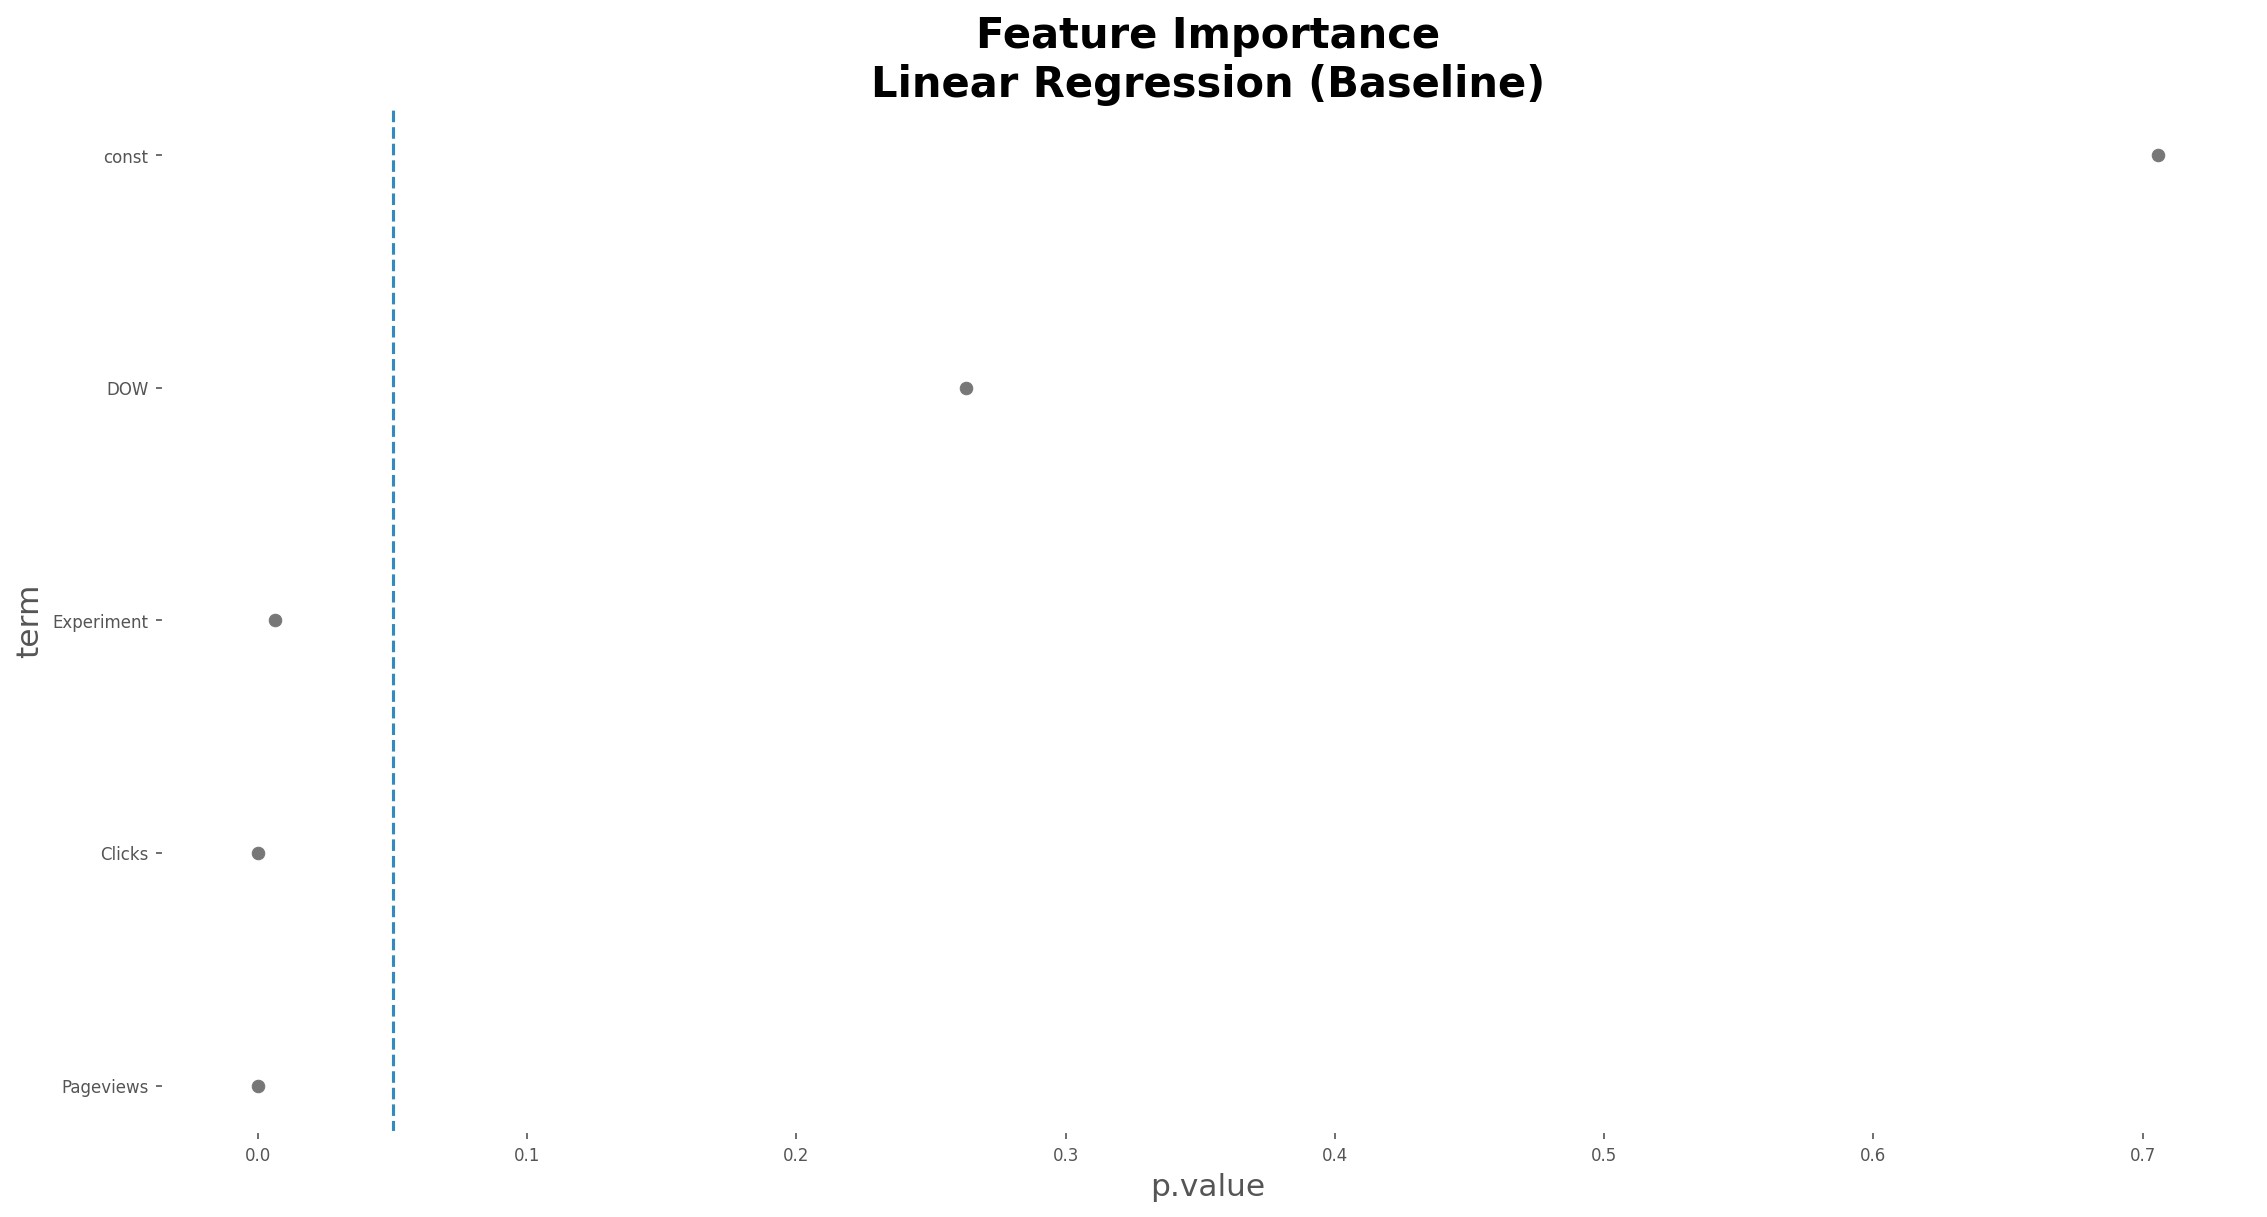

In [179]:
# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize = (15, 8))

# Scatter plot
ax.scatter(lr_term['p_value'], lr_term['Terms'], color=COLORS[3])

# Vertical line
ax.axvline(x=0.05, linestyle='--', color=COLORS[1])

# Set labels
ax.set_xlabel('p.value', fontsize = 15)
ax.set_ylabel('term', fontsize = 15)
ax.set_title('Feature Importance\nLinear Regression (Baseline)', fontsize = 20,
             fontweight = 'bold')

# Show the plot
plt.show()

+ Our model is on average off by +/-22 enrollments (in terms of means absolute error). The test set R-squared is negative indicating that the chosen model (linear regression in our case) does not follow the trend of the data; thereby it fits worse than a horizontal line.

+ We investigated feature importance. `Clicks`, `Pageviews`, and `Experiment` are the most important features. `Experiment` is 3rd, with a p.value 0.006. Typically this is considered significant.

+ We can also see the term coefficient for Experiment is marginally larger than -22.indicating as decreasing Enrollments by over **-22.** per day when the Experiment is run.

## **Decision Tree and Random Forest**


In [180]:
from sklearn.tree import DecisionTreeRegressor

dtree = DecisionTreeRegressor(max_depth=5, min_samples_leaf = 4, random_state=7)
dtree.fit(X_train_refined, y_train)
y_preds = dtree.predict(X_test_refined)

calculate_metrics(y_test, y_preds)

RMSE Score: 34.95282535074954
R2_Squared: -1.0241566704221614
MAE Score: 22.5


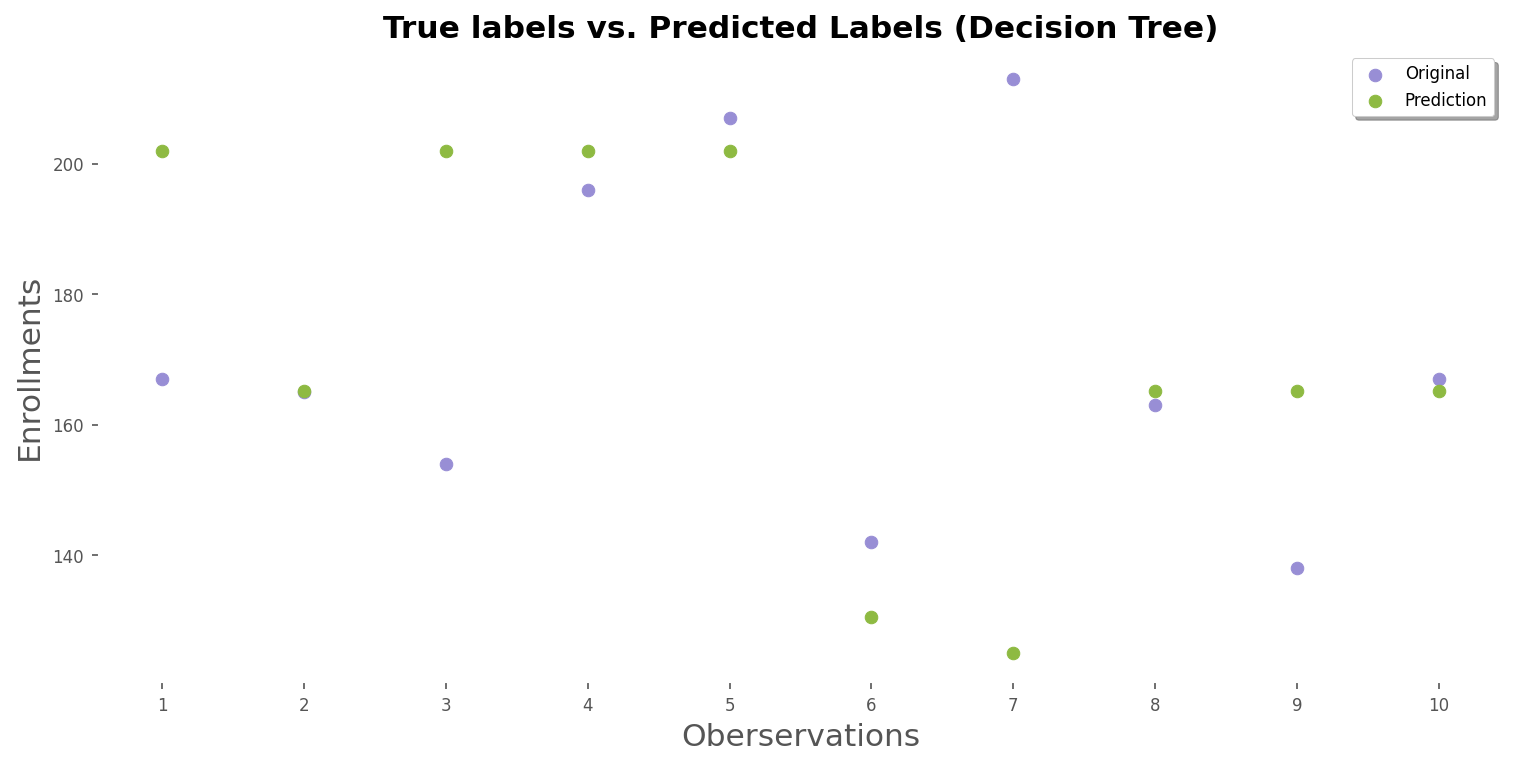

In [181]:
plot_preds(y_test, y_preds, 'Decision Tree')

In [182]:
from treeinterpreter import treeinterpreter as ti
prediction, bias, contributions = ti.predict(dtree, X_test_refined)

In [183]:
dtree_term = pd.DataFrame(np.sort(np.sum(contributions, axis = 0)),
          index = ['Experiment', 'const', 'DOW', 'Clicks', 'Pageviews'],
             columns = ['Contribution']).reset_index()\
             .rename(columns={'index':'Terms'})

In [184]:
dtree_term

,Terms,Contribution
0,Experiment,-19.615385
1,const,0.000000
2,DOW,0.000000
3,Clicks,73.367521
4,Pageviews,144.081197


In [185]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 3, random_state = 18)
rf.fit(X_train_refined, y_train)
y_preds = rf.predict(X_test_refined)
calculate_metrics(y_test, y_preds)

RMSE Score: 23.54098081596809
R2_Squared: 0.08181824876105515
MAE Score: 20.066666666666663


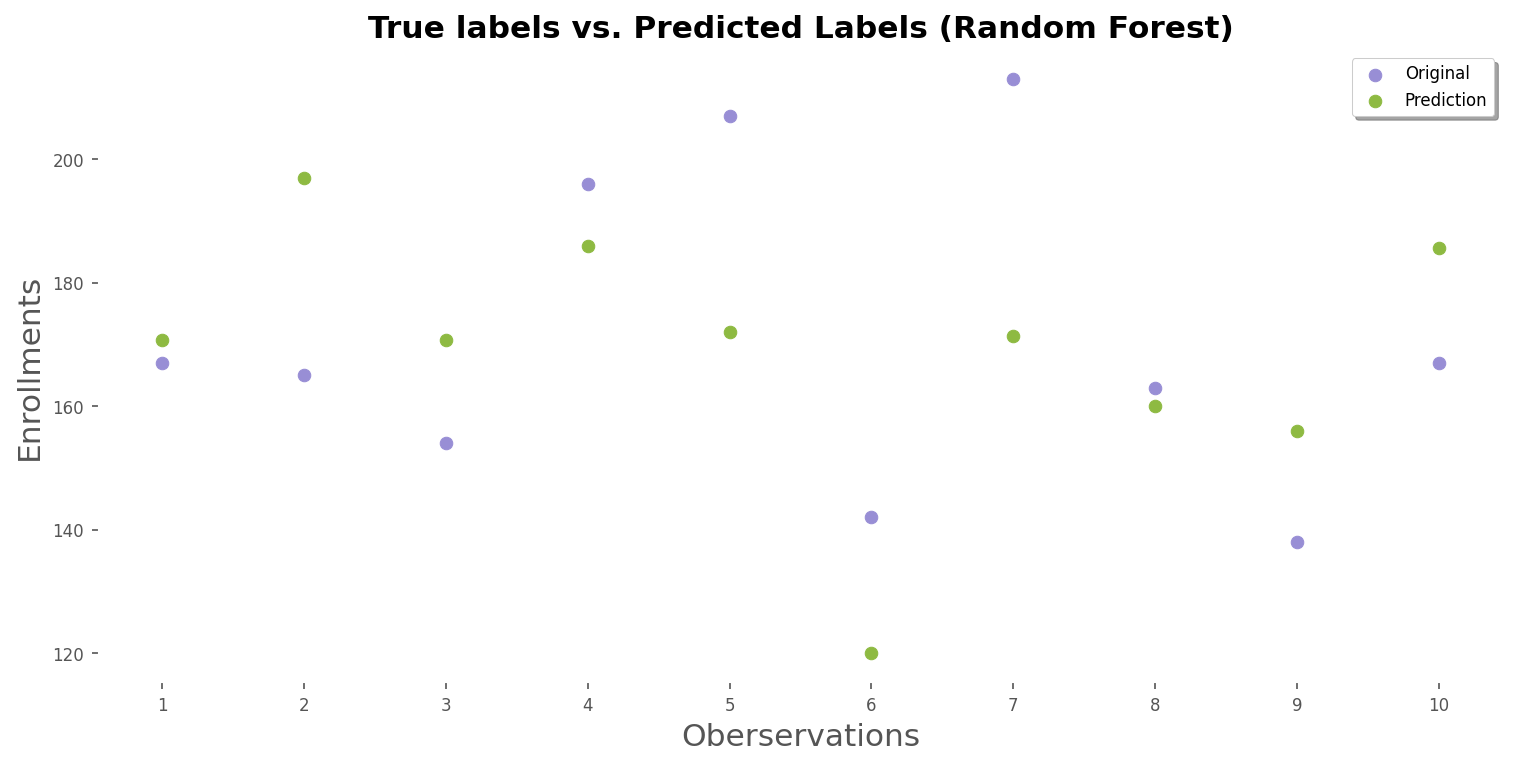

In [186]:
plot_preds(y_test, y_preds, 'Random Forest')

Text(0, 0.5, 'Mean decrease in impurity')

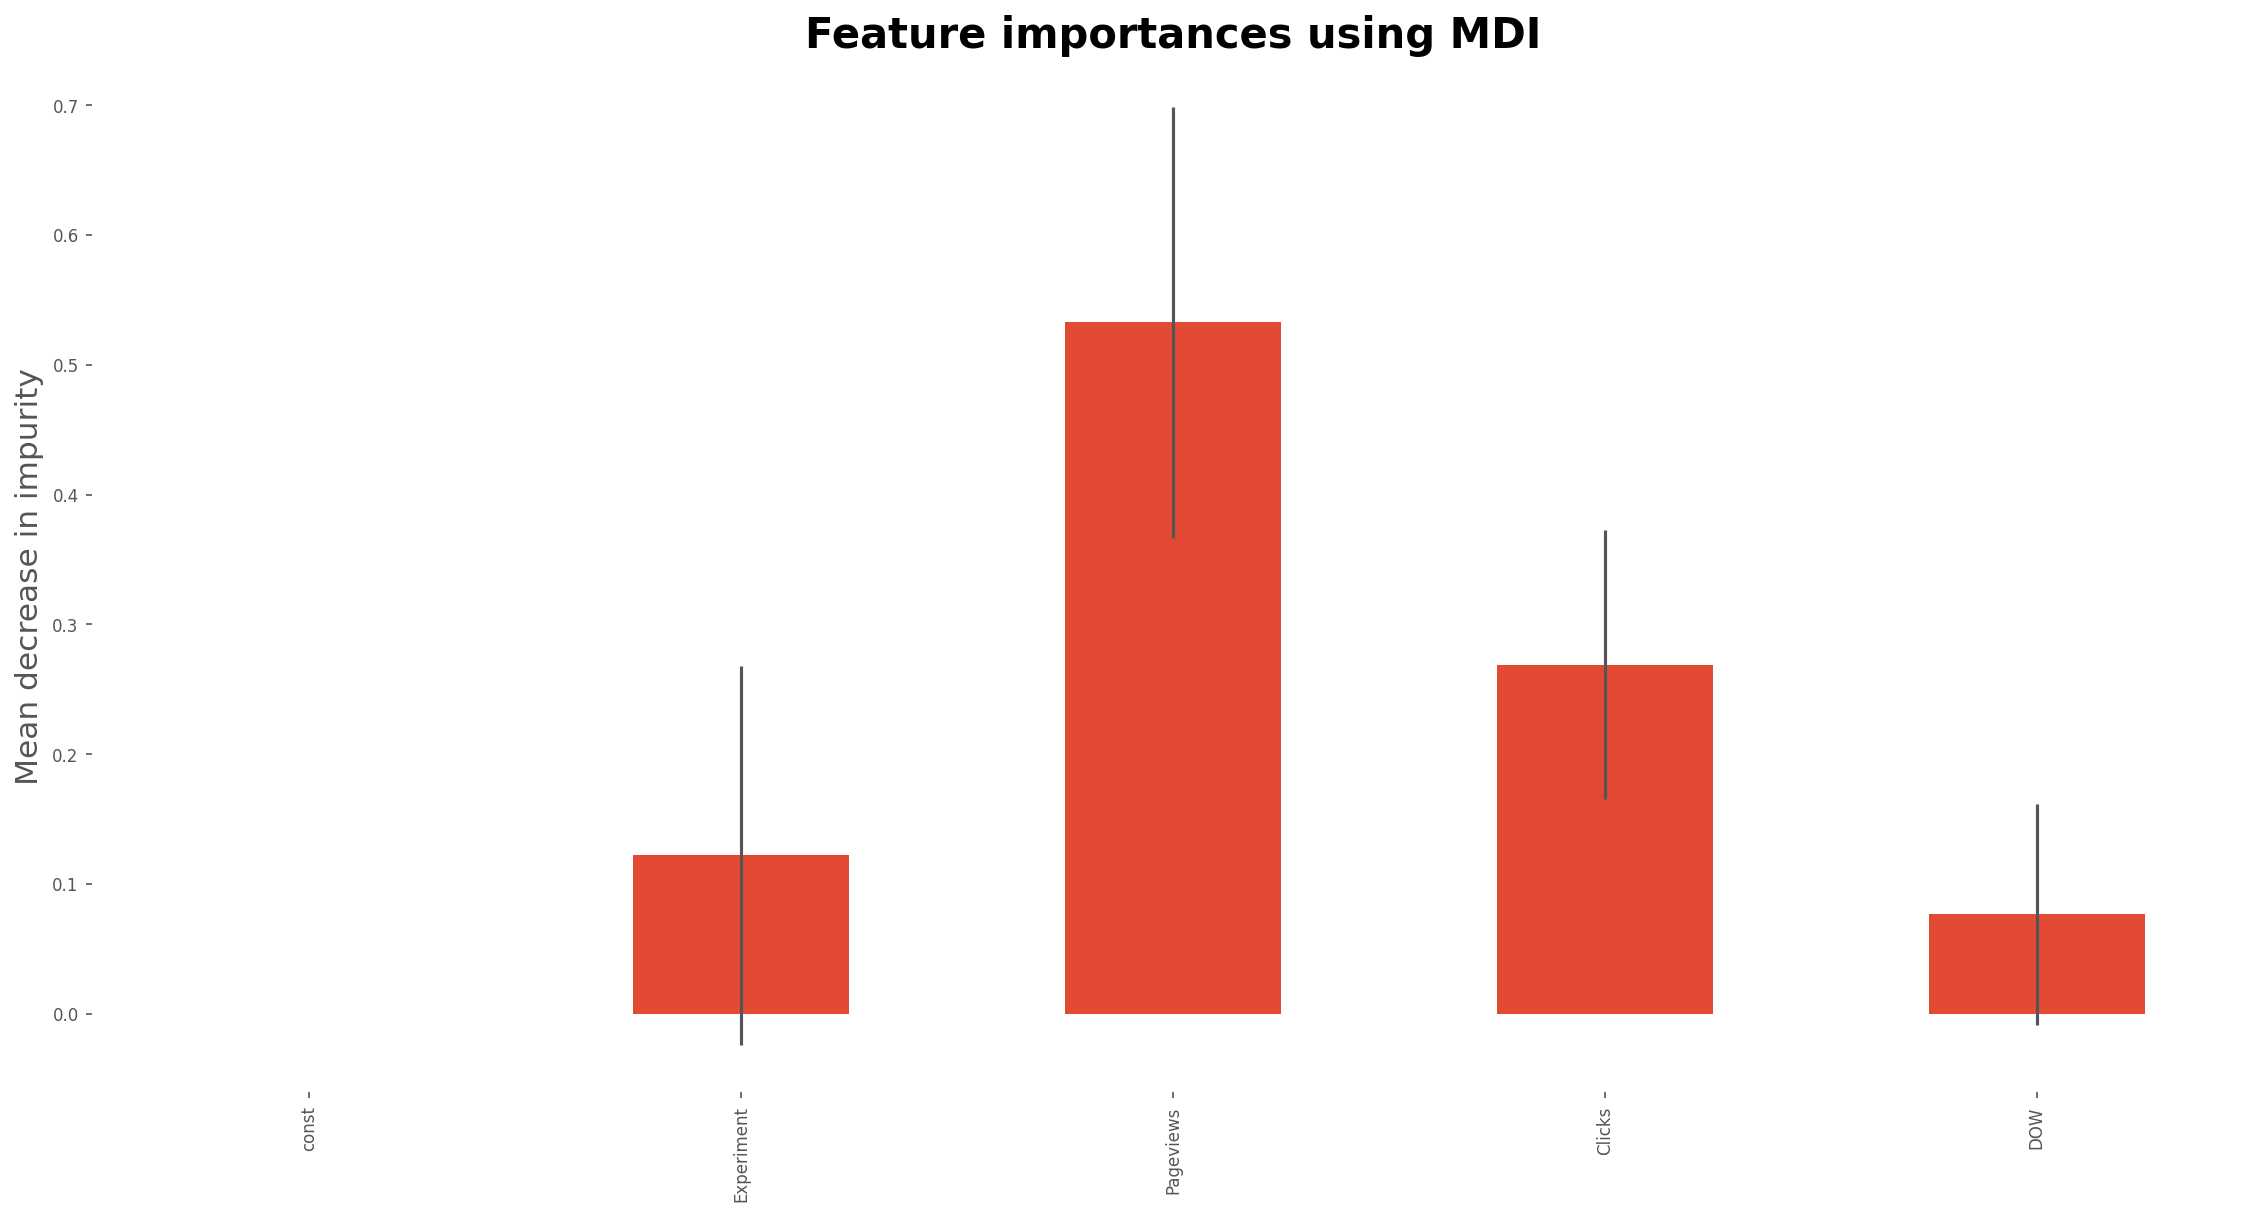

In [187]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
rf_importances = pd.Series(importances, index=X_train_refined.columns)
fig, ax = plt.subplots(figsize = (15, 8))
rf_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI", fontsize = 20, fontweight = "bold")
ax.set_ylabel("Mean decrease in impurity", fontsize = 15)

In [ ]:
prediction, bias, contributions = ti.predict(rf, X_test_refined)

In [189]:
rf_term = pd.DataFrame(np.sort(np.sum(contributions, axis = 0)),
          index = ['Experiment', 'const', 'DOW', 'Clicks', 'Pageviews'],
             columns = ['Contribution']).reset_index()\
             .rename(columns={'index':'Terms'})

In [190]:
rf_term

,Terms,Contribution
0,Experiment,-26.667677
1,const,0.000000
2,DOW,7.199285
3,Clicks,58.600481
4,Pageviews,96.960503


# **Conclusion**

Given the explanability of regression and ensembling models, we can discover that the system is driven by `Pageviews` and `Clicks`. Not only did we detect the effect of `Experiment` factor but we also measured its magnitude thanks to applied predictive modeling rather than traditional statistical inference.

If Udacity wants to maximimize enrollments, it should focus on increasing Page Views from qualified candidates. Page Views is the most important feature in both models.

If Udacity wants alert people of the time commitment, the additional popup form is expected to decrease the number of enrollments. The negative impact can be seen in the contribution of `Experiment` factor (contribute to the loss of 19 and 22.6 enrollments per day) by Decision Tree together with Random Forest, and in the linear regression model term (loss 22. Enrollments when the Experiment presents).

My recommendation would be not to launch this due to the decrease in enrollments can harm current benefits. We should research and adapt a new experiment.